

## Project Description

This notebook is a sentiment analysis (text classification) task . the goal is to build  GRU model to  predict the amazon mobile product review rating , by visualizing the attention weight on each word of a review that cause the rating prediction.

This lab was built by following these steps:

1-Propose a neural network using GRU model to predict each review rating <br>
2-Add an attention mechanism to this neural network <br>
3-Try to exploit the attention matrix and give some example <br> <br>
<br>

In [1]:
# Importing libraries

import warnings
warnings.filterwarnings(action="ignore")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Concatenate, dot, TimeDistributed,RepeatVector, Activation, Lambda,Attention,Dense,Flatten,Embedding,LSTM,GRU, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential

## Data Preprocessing

In [1]:
# fetching data
import pandas as pd

TRAIN = pd.read_csv("train.csv") 

VAL = pd.read_csv("val.csv") 

TEST = pd.read_csv("test.csv")

TRAIN.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,Samsung Galaxy Note 4 N910C Unlocked Cellphone...,Samsung,449.99,4,I love it!!! I absolutely love it!! 👌👍,0.0
1,BLU Energy X Plus Smartphone - With 4000 mAh S...,BLU,139.00,5,I love the BLU phones! This is my second one t...,4.0
2,Apple iPhone 6 128GB Silver AT&T,Apple,599.95,5,Great phone,1.0
3,BLU Advance 4.0L Unlocked Smartphone -US GSM -...,BLU,51.99,4,Very happy with the performance. The apps work...,2.0
4,Huawei P8 Lite US Version- 5 Unlocked Android ...,Huawei,198.99,5,Easy to use great price,0.0


#### Splitting Data

In [3]:
TRAIN['Rating'].value_counts()

5    2692
1     885
4     747
3     385
2     291
Name: Rating, dtype: int64

The data is imbalanced, so Precision may be a good metric for this task.

In [4]:
# Construct X_train and y_train
X_train = np.array(TRAIN['Reviews'].fillna("")).reshape((-1,1))
y_train = np.array(TRAIN['Rating']).reshape(-1,1)
X_train.shape, y_train.shape

((5000, 1), (5000, 1))

In [5]:
X_val = np.array(VAL['Reviews'].fillna("")).reshape((-1,1))
y_val= np.array(VAL['Rating']).reshape(-1,1)
X_val.shape, y_val.shape

((1000, 1), (1000, 1))

In [6]:
X_test = np.array(TEST['Reviews'].fillna("")).reshape((-1,1))
y_test = np.array(TEST['Rating']).reshape(-1,1)
X_test.shape, y_test.shape

((1000, 1), (1000, 1))

#### Data Encoding

In [7]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
y_train_encoded = ohe.fit_transform(y_train)
y_val_encoded = ohe.transform(y_val)
y_test_encoded = ohe.transform(y_test)

In [8]:
# Define constant
n_classes = len(np.unique(y_train))
feature_vector_length = X_train.shape[1]

feature_vector_length, n_classes

(1, 5)

#### Text Vectorization

In [9]:
# defining varaible

max_tokens = 4000
embedding_dim = 128
units = 64
batch_size=128
epochs=500
dropout_rate=0.5


vectorize_layer = layers.TextVectorization(output_mode='int', max_tokens=max_tokens)

vectorize_layer.adapt(X_train) 

print(vectorize_layer(X_train).shape)

vocab_size = len(vectorize_layer.get_vocabulary())

(5000, 1040)


## Building Models




###   Many-to-One GRU Model

In [10]:

inputs = layers.Input(shape=(1,), dtype=tf.string)
x=vectorize_layer(inputs)
x= layers.Embedding(vocab_size,embedding_dim,input_length=vocab_size,mask_zero=True)(x)

gru1 = GRU(units=units, return_sequences=True)(x)

gru2= GRU(units=units, return_sequences=True,dropout=dropout_rate, recurrent_dropout=dropout_rate)(gru1)

gru3 = GRU(units=units, return_sequences=False,dropout=dropout_rate, recurrent_dropout=dropout_rate)(gru2)


output = Dense(units=n_classes, activation='softmax')(gru3)

model = Model(inputs=inputs, outputs=output)


The model above is a many-to-one network with 3 GRU layers because  the input is a sequence of strings and the output is a single label that corresponds to the entire sequence. A dropout layer was added to drop out some of the units during training, which can prevent overfitting and improve generalization. The third GRU layer is also similar, but it is set to return only the final output of the sequence, rather than the output of each time step. This output is then passed through a dense layer with a softmax activation function, which maps the output to a probability distribution over the output classes.

In [11]:

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 128)         512000    
                                                                 
 gru (GRU)                   (None, None, 64)          37248     
                                                                 
 gru_1 (GRU)                 (None, None, 64)          24960     
                                                                 
 gru_2 (GRU)                 (None, 64)                24960     
                                                             

In [12]:

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.Precision()])


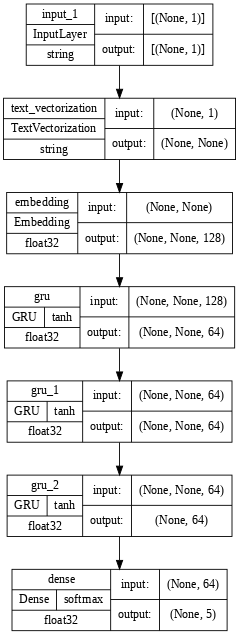

In [13]:
# Plot the model
plot_model(model, show_shapes=True,
    show_dtype=True,
    dpi=64,
    show_layer_activations=True,
)

In [14]:
callbacks_list = [EarlyStopping(monitor='val_precision', mode='max',
                                patience=10,
                                restore_best_weights=True)]
history = model.fit(X_train, y_train_encoded, validation_data=(X_val,y_val_encoded), callbacks=callbacks_list, batch_size=batch_size, epochs=epochs)

Epoch 1/500
40/40 [==============================] - 197s 4s/step - loss: 1.3875 - precision: 0.5743 - val_loss: 1.1735 - val_precision: 0.7054
Epoch 2/500
40/40 [==============================] - 163s 4s/step - loss: 1.0408 - precision: 0.7526 - val_loss: 0.9707 - val_precision: 0.7497
Epoch 3/500
40/40 [==============================] - 165s 4s/step - loss: 0.8696 - precision: 0.7653 - val_loss: 0.9638 - val_precision: 0.7652
Epoch 4/500
40/40 [==============================] - 154s 4s/step - loss: 0.7675 - precision: 0.7894 - val_loss: 1.0092 - val_precision: 0.7633
Epoch 5/500
40/40 [==============================] - 166s 4s/step - loss: 0.6859 - precision: 0.8161 - val_loss: 1.1143 - val_precision: 0.7333
Epoch 6/500
40/40 [==============================] - 166s 4s/step - loss: 0.6142 - precision: 0.8280 - val_loss: 1.1744 - val_precision: 0.7101
Epoch 7/500
40/40 [==============================] - 163s 4s/step - loss: 0.5718 - precision: 0.8319 - val_loss: 1.2575 - val_precision:

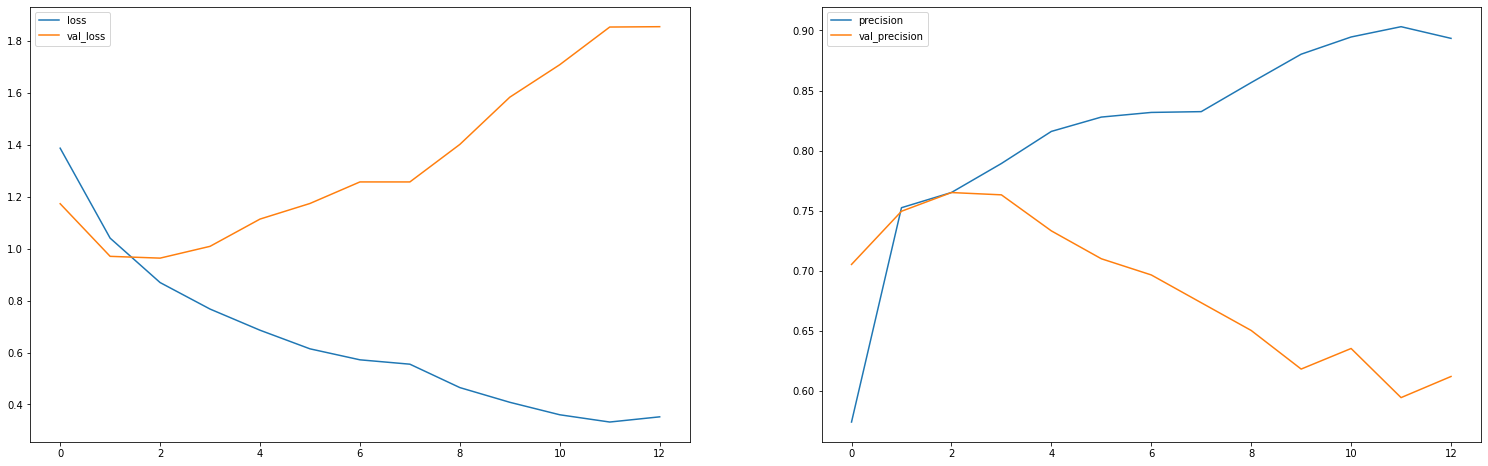

In [15]:
# Plot the learning curves and analyze them
""" your code here """
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26,8))

ax1.plot(history.history['loss'], label="loss")
ax1.plot(history.history['val_loss'], label="val_loss")
ax1.legend()
ax2.plot(history.history['precision'], label="precision")
ax2.plot(history.history['val_precision'], label="val_precision")
ax2.legend()
plt.show()

In [16]:
# Evaluate the  model on test data
""" your code here """
loss, precision = model.evaluate(X_test, y_test_encoded)
print('Precision on test data: %f' % (precision*100))
print('Loss on test data: %f' % (loss))

32/32 [==============================] - 6s 188ms/step - loss: 0.9924 - precision: 0.7392
Precision on test data: 73.918742
Loss on test data: 0.992380


32/32 [==============================] - 8s 187ms/step
 GRU MODEL CLASSIFICATION REPORT

               precision    recall  f1-score   support

           0       0.47      0.78      0.59       159
           1       0.00      0.00      0.00        51
           2       0.00      0.00      0.00        71
           3       0.26      0.04      0.07       163
           4       0.74      0.94      0.82       556

    accuracy                           0.65      1000
   macro avg       0.29      0.35      0.30      1000
weighted avg       0.53      0.65      0.56      1000



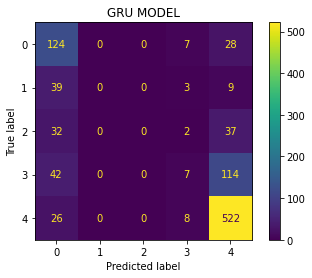

In [17]:
# prediction on test data

y_pred2=model.predict(X_test)
print(" GRU MODEL CLASSIFICATION REPORT\n\n",classification_report(np.argmax(y_test_encoded,axis=1),np.argmax(y_pred2,axis=1)))
cm=confusion_matrix(np.argmax(y_test_encoded,axis=1),np.argmax(y_pred2,axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.title("GRU MODEL")
plt.show()

This Network is  learning, the precision metric of the training is much higher than the validation set one  has been constant around 63%

The loss layer of the training data do reduce drastically throught the epoch but the validation set loss was inconsistent and was getting worst.

### Add Attention mechanism to model

In [18]:

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = vectorize_layer(inputs)
x = layers.Embedding(vocab_size, embedding_dim, input_length=vocab_size, mask_zero=True)(x)

gru1 = GRU(units=units, return_sequences=True)(x)
gru2 = GRU(units=units, return_sequences=True,dropout=dropout_rate, recurrent_dropout=dropout_rate)(gru1)
gru3 = GRU(units=units, return_sequences=True,dropout=dropout_rate, recurrent_dropout=dropout_rate)(gru2)


# Define the attention layer
attention_scores = layers.Dense(1, activation='tanh')(gru3)
attention_scores = layers.Flatten()(attention_scores)
attention_weights = layers.Activation('softmax')(attention_scores)
attention_weights = layers.RepeatVector(units)(attention_weights)
attention_weights = layers.Permute([2, 1])(attention_weights)

# Compute the context vector
weighted_hidden_states = layers.multiply([gru3, attention_weights])
context_vector = layers.Lambda(lambda x: K.sum(x, axis=1))(weighted_hidden_states)


# Define the output layer
outputs = layers.Dense(n_classes, activation='softmax')(context_vector)

# Create the model
attention_model = Model(inputs=inputs, outputs=outputs)


Here an  attention mechanism is added on top of the 3 GRU layers to better focus on relevant parts of the input sequence because the return sequence of the last layer is True. First an attention score layer  is defined which takes the output of the last GRU layer as input and applies a dense layer with a "tanh" activation function to generate a score for each hidden state in the sequence. The score is then flattened and passed through a softmax activation function to generate a weight for each hidden state. These weights represent the relevance of each hidden state to the final output. Then The attention weights are then multiplied with the GRU output sequence using the "multiply" layer. This results in a weighted sequence of hidden states, where the more relevant hidden states have a higher weight. The context vector is then computed by taking the sum of the weighted sequence along the sequence axis.

I use The layers.RepeatVector() layer  to replicate the attention weights vector across time steps, effectively increasing the number of dimensions in the tensor, The layers.Permute() layer  to transpose the dimensions of the attention weights tensor and The Lambda layer with K.sum() function is then used to compute the context vector by summing over the sequence_length dimension of the weighted hidden states tensor. Finally, the context vector is passed through a dense layer with a softmax activation function to generate the final output probabilities.  Overall, this network architecture uses attention to focus on the most relevant parts of the input sequence, which should improve the model's ability to classify sequences accurately.

In [19]:

attention_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, None)        0           ['input_2[0][0]']                
 ization)                                                                                         
                                                                                                  
 embedding_1 (Embedding)        (None, None, 128)    512000      ['text_vectorization[1][0]']     
                                                                                                  
 gru_3 (GRU)                    (None, None, 64)     37248       ['embedding_1[0][0]']      

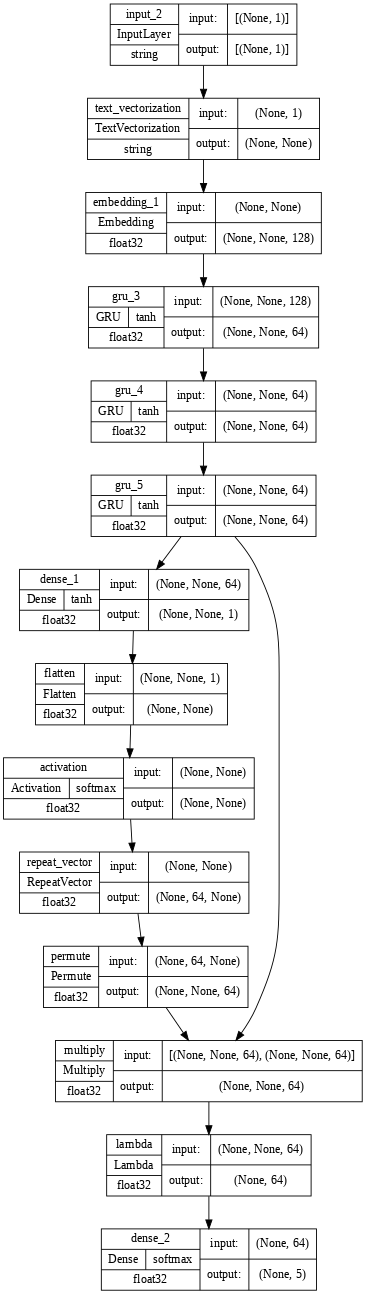

In [20]:
# Plot the model
plot_model(attention_model, show_shapes=True,
    show_dtype=True,
    dpi=64,
    show_layer_activations=True,
)

In [21]:
attention_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.Precision()])

In [22]:
callbacks_list2 = [EarlyStopping(monitor='val_precision_1', mode='max',
                                patience=15,
                                restore_best_weights=True)]
history2 = attention_model.fit(X_train, y_train_encoded, validation_data=(X_val,y_val_encoded), callbacks=callbacks_list2, batch_size=batch_size,epochs=epochs)

Epoch 1/500
40/40 [==============================] - 202s 5s/step - loss: 1.3721 - precision_1: 0.5988 - val_loss: 1.1541 - val_precision_1: 0.7585
Epoch 2/500
40/40 [==============================] - 171s 4s/step - loss: 1.0392 - precision_1: 0.7569 - val_loss: 0.9777 - val_precision_1: 0.7601
Epoch 3/500
40/40 [==============================] - 165s 4s/step - loss: 0.8456 - precision_1: 0.7740 - val_loss: 0.9224 - val_precision_1: 0.7662
Epoch 4/500
40/40 [==============================] - 178s 4s/step - loss: 0.7482 - precision_1: 0.7872 - val_loss: 0.9794 - val_precision_1: 0.7869
Epoch 5/500
40/40 [==============================] - 167s 4s/step - loss: 0.6654 - precision_1: 0.8275 - val_loss: 1.0541 - val_precision_1: 0.7334
Epoch 6/500
40/40 [==============================] - 176s 4s/step - loss: 0.6121 - precision_1: 0.8361 - val_loss: 1.1144 - val_precision_1: 0.7259
Epoch 7/500
40/40 [==============================] - 175s 4s/step - loss: 0.5339 - precision_1: 0.8445 - val_los

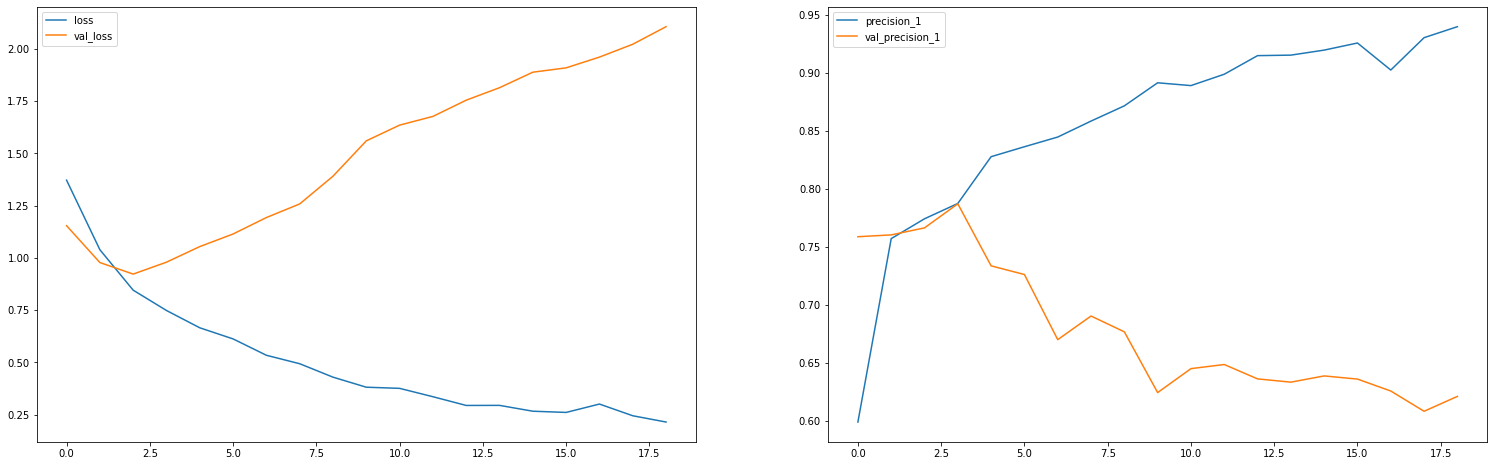

In [23]:
# Plot the learning curves and analyze them
""" your code here """
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26,8))

ax1.plot(history2.history['loss'], label="loss")
ax1.plot(history2.history['val_loss'], label="val_loss")
ax1.legend()
ax2.plot(history2.history['precision_1'], label="precision_1")
ax2.plot(history2.history['val_precision_1'], label="val_precision_1")
ax2.legend()
plt.show()

In [24]:
# Evaluate the model
""" your code here """
loss, precision = model.evaluate(X_test, y_test_encoded)
print('Precision on test data: %f' % (precision*100))
print('Loss on test data: %f' % (loss))

32/32 [==============================] - 6s 190ms/step - loss: 0.9924 - precision: 0.7392
Precision on test data: 73.918742
Loss on test data: 0.992380


32/32 [==============================] - 8s 190ms/step
 GRU + ATTENTION MODEL CLASSIFICATION REPORT

               precision    recall  f1-score   support

           0       0.56      0.65      0.60       159
           1       0.00      0.00      0.00        51
           2       0.14      0.07      0.09        71
           3       0.28      0.28      0.28       163
           4       0.79      0.87      0.83       556

    accuracy                           0.64      1000
   macro avg       0.35      0.37      0.36      1000
weighted avg       0.58      0.64      0.61      1000



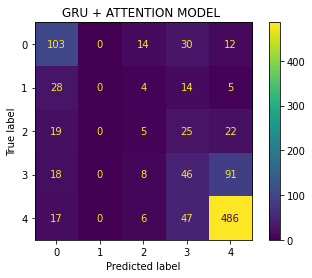

In [25]:
# Prediction on test data
y_pred2=attention_model.predict(X_test)
print(" GRU + ATTENTION MODEL CLASSIFICATION REPORT\n\n",classification_report(np.argmax(y_test_encoded,axis=1),np.argmax(y_pred2,axis=1)))
cm=confusion_matrix(np.argmax(y_test_encoded,axis=1),np.argmax(y_pred2,axis=1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.title("GRU + ATTENTION MODEL ")
plt.show()

this model overfit because it has a great precision score on the trainind tata while the score of the validation data get decreasing.

### Extracting Attention Matrix and Attention Weight Visualization 

In [26]:
attention_output1 = attention_model.layers[7].output
attention_weight_model= Model(inputs=inputs, outputs=attention_output1)

The attention_weight_model that takes the same input ( a string) as the original model attention_model, but outputs the attention weights tensor computed by the attention layer in attention_model. The layers[7] syntax to access the output of the 7th layer in the original attention_model, which corresponds to the attention weights layer. This model is use to compute the attention weights for a given input sequence as shown below on a given sentence.

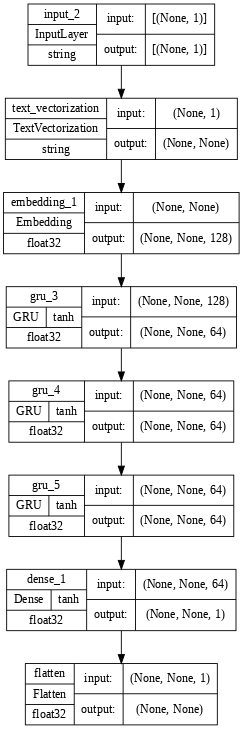

In [27]:

plot_model(attention_weight_model, show_shapes=True, show_dtype=True,dpi=64,show_layer_activations=True)

1/1 [==============================] - 2s 2s/step


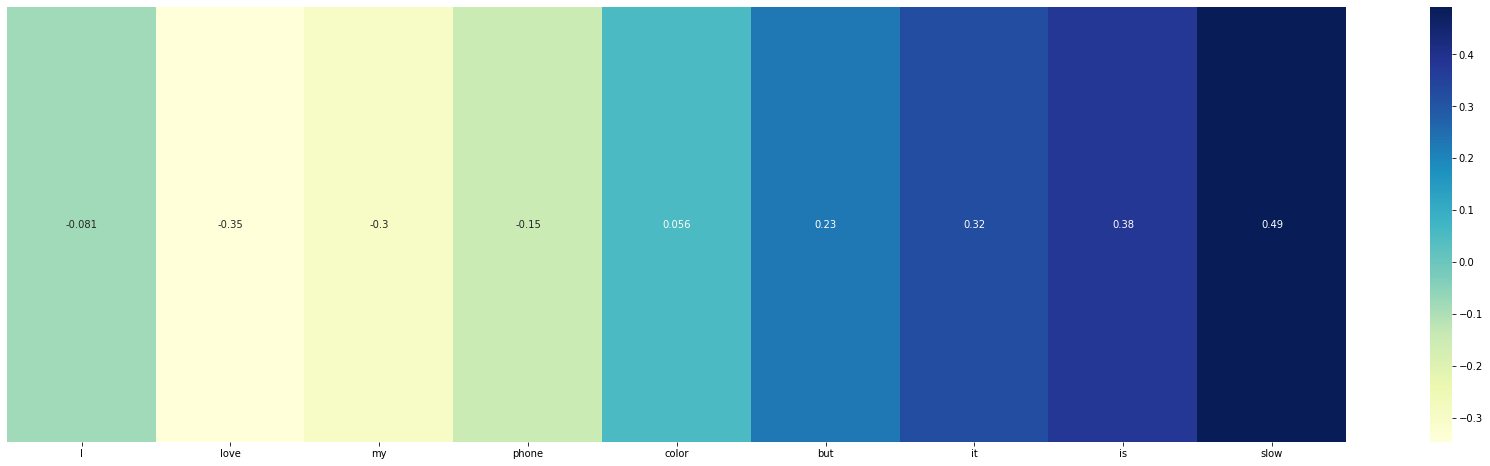

In [28]:
fig= plt.figure( figsize=(30, 8 ))

# Attention weight on a single sentence
sample_text = "I love my phone color but it is slow"

attention_matrix = attention_weight_model.predict([sample_text])


sns.heatmap(attention_matrix, annot=True, cmap='YlGnBu', xticklabels=sample_text.split(), yticklabels=False)
plt.show()

1/1 [==============================] - 0s 52ms/step


<Figure size 1296x360 with 0 Axes>

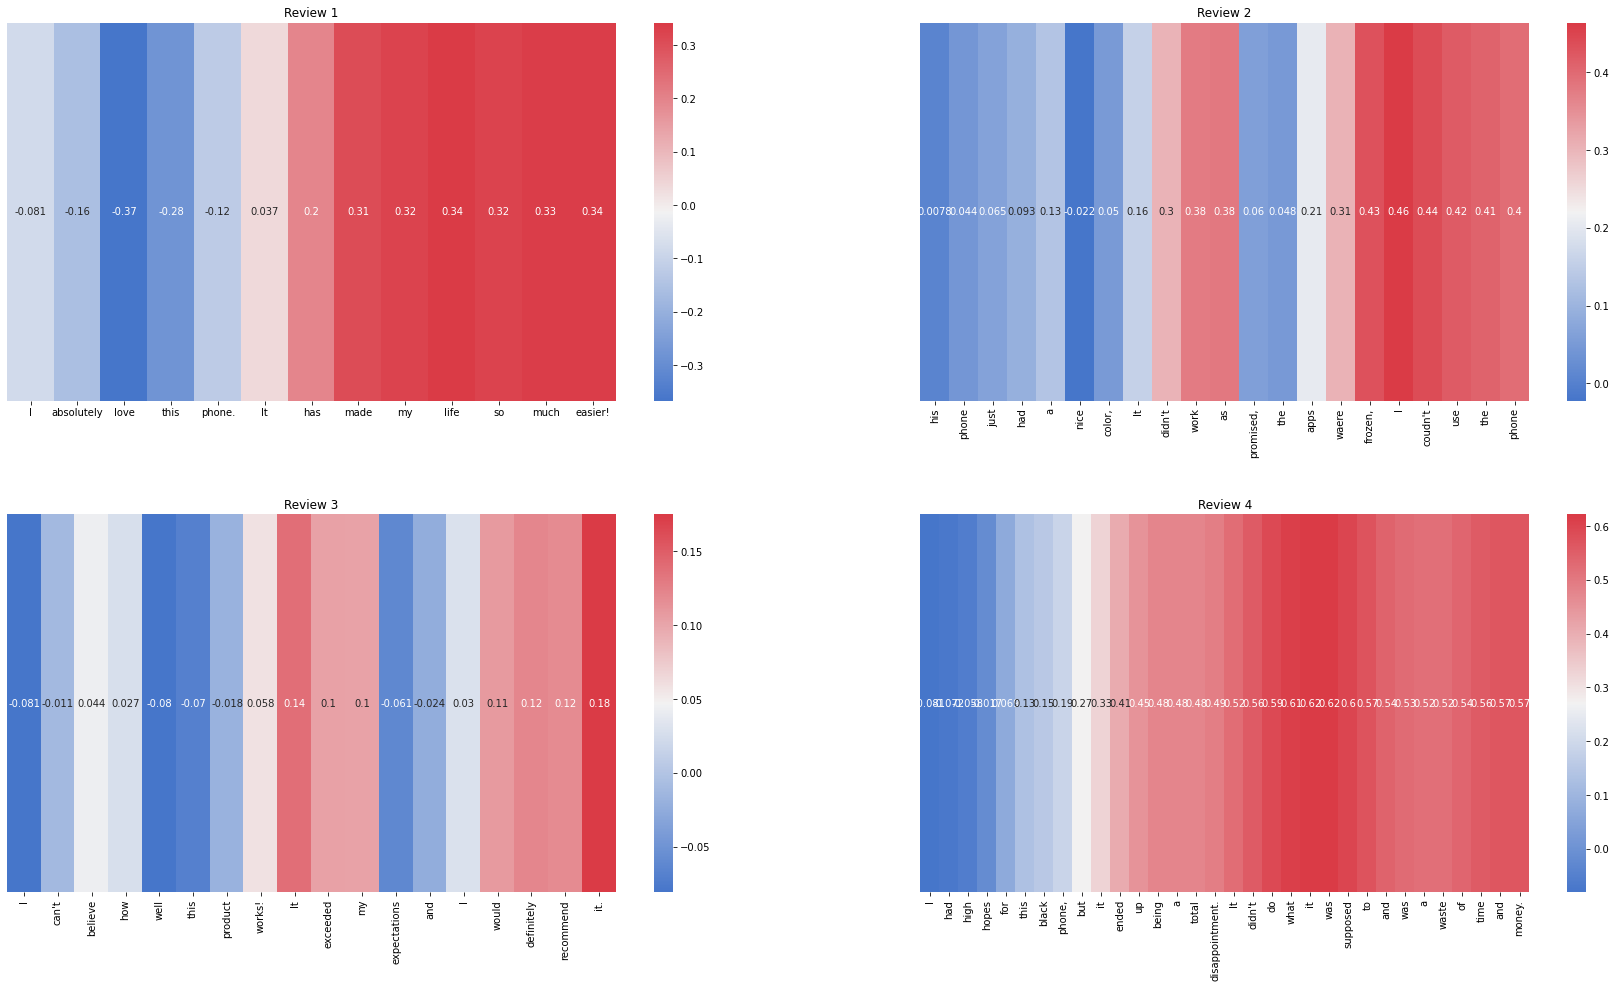

In [29]:
# attention matrix on a list of user-defined reviews

fig = plt.figure(figsize=(18, 5))

reviews = ["I absolutely love this phone. It has made my life so much easier!",   
           "his phone just had a nice color, It didn't work as promised, the apps waere frozen, I coudn't use the phone",    
           "I can't believe how well this product works! It exceeded my expectations and I would definitely recommend it.",  
           "I had high hopes for this black phone, but it ended up being a total disappointment. It didn't do what it was supposed to and was a waste of time and money."]


fig, axes = plt.subplots(2, 2, figsize=(30, 8 * 2))
cmap = sns.diverging_palette(255, 10, as_cmap=True)
for i, ax in enumerate(axes.flat):
    if i < len(reviews):
        attention_matrix = attention_weight_model.predict([reviews[i]])
        sns.heatmap(attention_matrix, annot=True, cmap=cmap, xticklabels=reviews[i].split(),  yticklabels=False, ax=ax)
        ax.set_title(f"Review {i+1}")
    else:
        ax.set_visible(False)
fig.subplots_adjust(wspace=0.2, hspace=0.3)
plt.show()


## Attention Weight Prediction on Test Data with Predicted rating

In [30]:
attention_weight_pred_model= Model(inputs=inputs, outputs=[attention_output1,outputs])

The attention_weight_pred_model is defined to analyze the attention mechanism of the model and visualize the attention weights for a given input sequence. By calling this model on an input sequence, we can obtain the attention weights as well as the final classification probabilities. The attention weights will  be used to generate a visualization of the input sentence with highlights indicating the most important words or tokens for the prediction.

Overall, the attention_weight_pred_model is an extension of the attention_model that generate the predicted output and the attention weight of a given sentence.

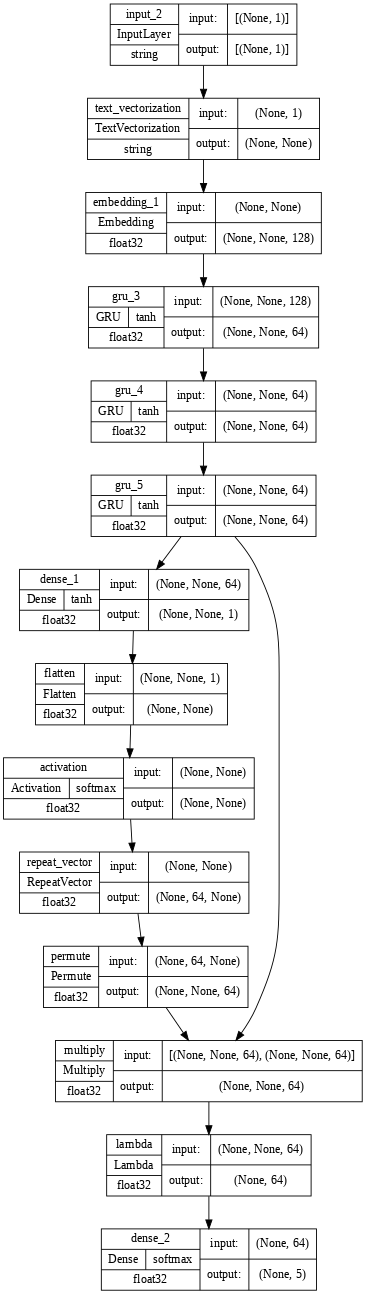

In [31]:

plot_model(attention_weight_pred_model, show_shapes=True, show_dtype=True,dpi=64,show_layer_activations=True)

1/1 [==============================] - 0s 70ms/step


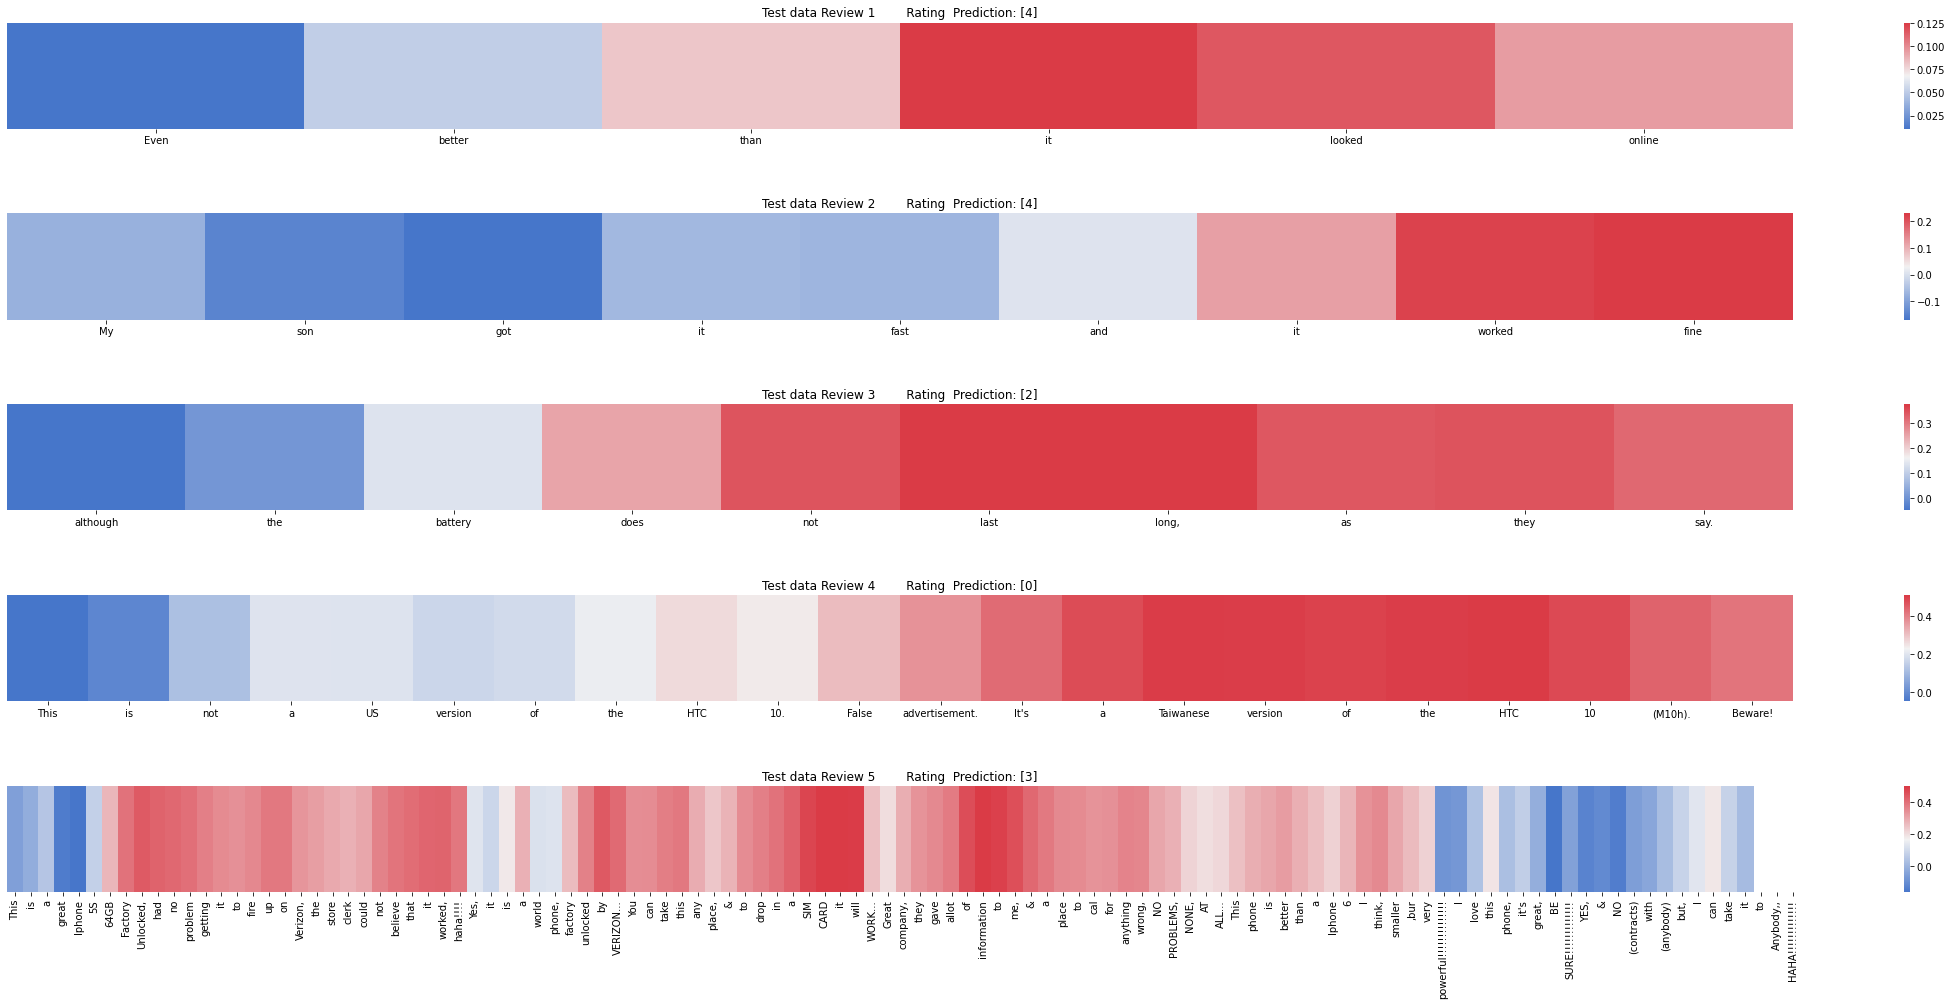

In [32]:
# Attention matrix on 5 reviews from the test data with their predictions


test_data_reviews=[" ".join(map(str,p)) for p in X_test[39:44]]

fig, axes = plt.subplots(len(test_data_reviews), 1, figsize=(40, 8 * 2))
for i, ax in enumerate(axes.flat):
    if i < len(test_data_reviews):
      attention_matrix,pred = attention_weight_pred_model.predict([[test_data_reviews[i]]])
      sns.heatmap(attention_matrix, cmap=cmap, xticklabels=test_data_reviews[i].split(),  yticklabels=False, ax=ax)
      ax.set_title(f"Test data Review {i+1}        Rating  Prediction: {np.argmax(pred,axis=1)}")
    else:
        ax.set_visible(False)
fig.subplots_adjust(wspace=0.2, hspace=0.8)
plt.show()

From the visualization above, for each sentences we can clearly see which word the attention_model pays more weights to in order to make a prediction.